In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
# import optuna


pd.set_option('display.max_columns', None)

In [2]:
rfm_df = pd.read_excel('rfm_df.xlsx')
rfm_df

,Телефон_new,quarter,total_orders,unique_sku,avg_sku_per_order,avg_check,med_check,avg_sku_check,med_sku_check,mean_days_between_orders,median_days_between_orders,total_margin,defect_ratio,delivery_method,good_type,Geo,ДЕТСКОЕ ПИТАНИЕ,ЖЕНСКИЕ ШТУЧКИ,ИГРУШКИ,"КАНЦТОВАРЫ, КНИГИ, ДИСКИ",КОСМЕТИКА/ГИГИЕНА,КРУПНОГАБАРИТНЫЙ ТОВАР,ОБУВЬ,ПОДГУЗНИКИ,СОПУТСТВУЮЩИЕ ТОВАРЫ,"ТЕКСТИЛЬ, ТРИКОТАЖ",ТЕХНИКА И ТОВАРЫ ДЛЯ ДОМА,ТОВАРЫ ДЛЯ ЖИВОТНЫХ,ТОВАРЫ ДЛЯ КОРМЛЕНИЯ,R_Score,F_Score,M_Score,RFM_Segment,segment_group,cluster_kmeans,cluster_gmm
0,55525753-50494856495470,2017Q2,1,2,1.00,4809.000000,4809.0,2404.500000,2404.5,0.0,0.0,600.00,0.500000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,1,2,312,Freshers,7,0
1,55525753-50535655495477,2017Q1,1,2,1.00,900.000000,900.0,300.000000,300.0,0.0,0.0,138.00,0.600000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,1,1,311,Freshers,5,5
2,55525753-53565350484974,2017Q1,2,3,1.00,2999.333333,3300.0,912.666667,1100.0,15.0,15.0,579.08,0.000000,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,1,2,2,122,At Churn Risk,5,5
3,55525753-54565357505774,2017Q2,1,3,1.00,3880.000000,3880.0,125.333333,122.0,0.0,0.0,444.55,0.400000,5,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,3,1,2,312,Freshers,13,8
4,55525753-55515454494872,2017Q3,1,6,1.00,3668.000000,3668.0,346.666667,199.5,0.0,0.0,628.40,0.538462,0,0,0,3,0,0,0,0,1,0,1,0,0,0,0,0,3,1,2,312,Freshers,11,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231695,57485355-52485257575698,2017Q1,1,1,1.00,2076.000000,2076.0,2076.000000,2076.0,0.0,0.0,238.00,0.000000,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,1,1,311,Freshers,5,5
231696,57495351-50535151545597,2017Q3,1,6,1.00,1827.000000,1827.0,523.000000,161.0,12.0,0.0,343.63,0.000000,1,0,0,0,0,2,0,1,0,0,0,0,0,0,2,0,2,1,2,212,Sleeping,0,9
231697,57505754-52565350494991,2017Q1,1,2,1.00,8303.000000,8303.0,4151.500000,4151.5,0.0,0.0,954.22,0.333333,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,3,1,3,313,Freshers,5,5
231698,57545549-57544957525799,2017Q2,1,1,1.00,2560.000000,2560.0,2560.000000,2560.0,0.0,0.0,294.00,0.909091,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,1,2,312,Freshers,9,0


In [4]:
segment_counts_per_quarter = rfm_df.groupby('quarter')['segment_group'].value_counts().unstack(fill_value=0)
segment_counts_per_quarter


segment_group,At Churn Risk,Drifting,Freshers,Lost,Loyal,Sleeping,VIP
quarter,,,,,,,
2017Q1,17246,2846,28611,3857,4592,4412,516
2017Q2,8761,8397,18781,14166,3623,13951,453
2017Q3,4833,6267,14366,17786,5569,15521,2213
2017Q4,786,2887,6897,10968,1843,8629,2923


In [5]:
# Short Preprocessing 

rfm_model_df = rfm_df[rfm_df['quarter'] != '2017Q1'].copy()
rfm_model_df = rfm_model_df.dropna(subset=['segment_group'])

In [6]:
le = LabelEncoder()
rfm_model_df['segment_encoded'] = le.fit_transform(rfm_model_df['segment_group'])


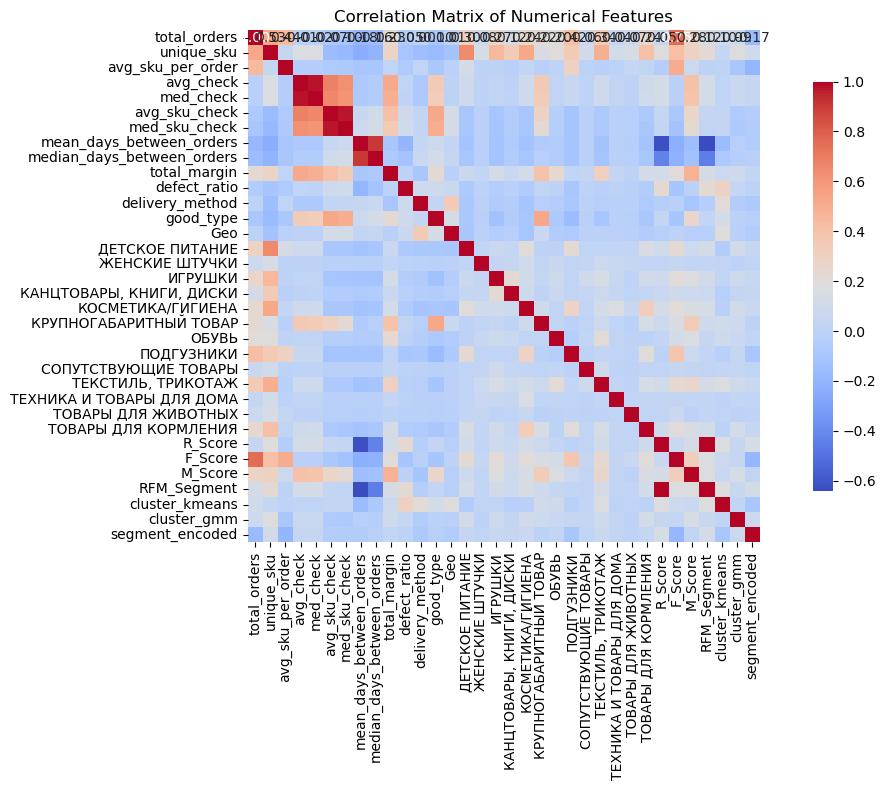

In [7]:
# Correlation Matrix
numeric_df = rfm_model_df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f', square=True, cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()


In [8]:
drop_cols = ['Телефон_new', 'quarter', 
             'R_Score', 'F_Score', 'M_Score', 
             'RFM_Segment', 'segment_group', 
             'total_margin', 'total_orders'
            ]
feature_cols = [col for col in rfm_model_df.columns if col not in drop_cols + ['segment_encoded']]

X = rfm_model_df[feature_cols].select_dtypes(include=['number'])
y = rfm_model_df['segment_encoded']

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# Distribution by classes in the train
train_distribution = pd.Series(y_train).value_counts(normalize=True).rename('train_share')
train_distribution

segment_encoded
3    0.253036
2    0.236079
5    0.224627
1    0.103474
0    0.084778
4    0.065057
6    0.032949
Name: train_share, dtype: float64

In [12]:
# Distribution by classes in the test
test_distribution = pd.Series(y_test).value_counts(normalize=True).rename('test_share')
test_distribution

segment_encoded
3    0.253036
2    0.236087
5    0.224620
1    0.103467
0    0.084778
4    0.065057
6    0.032956
Name: test_share, dtype: float64

--------

# Class Prediction

## LogisticRegression

In [13]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

In [14]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      2876
           1       0.66      0.63      0.64      3510
           2       0.88      0.91      0.90      8009
           3       0.92      0.91      0.91      8584
           4       0.58      0.60      0.59      2207
           5       0.77      0.66      0.71      7620
           6       0.32      0.56      0.41      1118

    accuracy                           0.78     33924
   macro avg       0.70      0.72      0.70     33924
weighted avg       0.79      0.78      0.79     33924



## RandomForestClassifier

In [15]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      2876
           1       0.87      0.79      0.83      3510
           2       0.94      0.98      0.96      8009
           3       0.97      0.99      0.98      8584
           4       0.78      0.77      0.78      2207
           5       0.90      0.93      0.92      7620
           6       0.79      0.59      0.67      1118

    accuracy                           0.92     33924
   macro avg       0.89      0.85      0.87     33924
weighted avg       0.92      0.92      0.92     33924



## GradientBoostingClassifier

In [17]:
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

In [18]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2876
           1       0.83      0.73      0.78      3510
           2       0.91      0.96      0.94      8009
           3       0.95      0.98      0.96      8584
           4       0.71      0.67      0.69      2207
           5       0.87      0.89      0.88      7620
           6       0.69      0.50      0.58      1118

    accuracy                           0.89     33924
   macro avg       0.84      0.80      0.82     33924
weighted avg       0.88      0.89      0.88     33924



## KNeighborsClassifier

In [19]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.64      0.60      0.62      2876
           1       0.56      0.57      0.56      3510
           2       0.69      0.84      0.76      8009
           3       0.90      0.90      0.90      8584
           4       0.40      0.28      0.33      2207
           5       0.54      0.51      0.53      7620
           6       0.43      0.18      0.26      1118

    accuracy                           0.68     33924
   macro avg       0.59      0.56      0.56     33924
weighted avg       0.66      0.68      0.67     33924



## CatBoostClassifier

In [21]:
catboost = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0,
    auto_class_weights='Balanced'
)

In [22]:
catboost.fit(X_train, y_train)
y_pred_catboost = catboost.predict(X_test)

In [23]:
print(classification_report(y_test, y_pred_catboost))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      2876
           1       0.80      0.87      0.83      3510
           2       0.97      0.95      0.96      8009
           3       0.98      0.97      0.97      8584
           4       0.76      0.78      0.77      2207
           5       0.95      0.86      0.90      7620
           6       0.62      0.80      0.69      1118

    accuracy                           0.91     33924
   macro avg       0.85      0.88      0.87     33924
weighted avg       0.92      0.91      0.91     33924



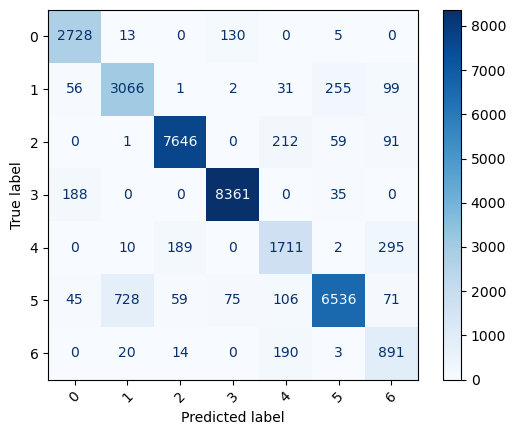

In [24]:
cm = confusion_matrix(y_test, y_pred_catboost, labels=catboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost.classes_)
disp.plot(xticks_rotation=45, cmap='Blues')

-------

# Hyperparameter Selection (WIP)

## optuna

In [67]:
X = rfm_model_df[feature_cols].select_dtypes(include='number')
y = rfm_model_df['segment_encoded']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [68]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 1000),
        "depth": trial.suggest_int("depth", 4, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.15),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "random_strength": trial.suggest_float("random_strength", 0.1, 1.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "auto_class_weights": "Balanced",
        "random_seed": 42,
        "verbose": 0
    }

    model = CatBoostClassifier(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        early_stopping_rounds=30,
        verbose=0
    )
    
    preds = model.predict(X_test)
    return f1_score(y_test, preds, average="macro")

In [69]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2025-04-12 21:22:34,919] A new study created in memory with name: no-name-e24e0289-78a9-46cf-baac-953e979bae9c
[I 2025-04-12 21:22:36,397] Trial 0 finished with value: 0.07412172940413318 and parameters: {'iterations': 639, 'depth': 5, 'learning_rate': 0.024925774941377148, 'l2_leaf_reg': 9.382335992859286, 'random_strength': 0.281777663836365, 'bagging_temperature': 0.2515817084398445}. Best is trial 0 with value: 0.07412172940413318.
[I 2025-04-12 21:22:37,742] Trial 1 finished with value: 0.07534207991509186 and parameters: {'iterations': 617, 'depth': 5, 'learning_rate': 0.059460810486603934, 'l2_leaf_reg': 8.214742753198218, 'random_strength': 0.6688140372753885, 'bagging_temperature': 0.36357341765833906}. Best is trial 1 with value: 0.07534207991509186.
[I 2025-04-12 21:22:39,251] Trial 2 finished with value: 0.07412172940413318 and parameters: {'iterations': 393, 'depth': 6, 'learning_rate': 0.03585204194248389, 'l2_leaf_reg': 3.0243402798495937, 'random_strength': 0.4837690

In [70]:
# Best trial:
print(study.best_trial.params)

{'iterations': 201, 'depth': 8, 'learning_rate': 0.11128980702306884, 'l2_leaf_reg': 6.989932384743744, 'random_strength': 0.6610614349143911, 'bagging_temperature': 0.7546018806713117}


## GridSearchCV

In [76]:
catboost_model = CatBoostClassifier(
    auto_class_weights='Balanced',
    verbose=0,
    random_seed=42
)

In [ ]:
param_grid = {
    'iterations': [300, 500],
    'depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'l2_leaf_reg': [3, 5, 7]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1
)

In [79]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x30e1aaa90>,
             n_jobs=-1,
             param_grid={'depth': [6, 8], 'iterations': [300, 500],
                         'l2_leaf_reg': [3, 5, 7],
                         'learning_rate': [0.05, 0.1]},
             scoring='f1_macro')

In [80]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"\nBest macro F1-score: {grid_search.best_score_}")

Best parameters: {'depth': 8, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.1}

Best macro F1-score: 0.7766406859224254


In [88]:
best_model = grid_search.best_estimator_

In [94]:
y_pred = best_model.predict(X_test)

In [95]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2876
           1       0.00      0.00      0.00      3510
           2       0.27      0.99      0.43      8009
           3       1.00      0.00      0.00      8584
           4       0.10      0.16      0.12      2207
           5       0.00      0.00      0.00      7620
           6       0.00      0.00      0.00      1118

    accuracy                           0.24     33924
   macro avg       0.20      0.16      0.08     33924
weighted avg       0.32      0.24      0.11     33924



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
print(y_test.value_counts(normalize=True).sort_index())


segment_encoded
0    0.084778
1    0.103467
2    0.236087
3    0.253036
4    0.065057
5    0.224620
6    0.032956
Name: proportion, dtype: float64


## Use best params

In [57]:
# best_params = {
#     'iterations': 386,
#     'depth': 10,
#     'learning_rate': 0.2534809710390702,
#     'l2_leaf_reg': 8.709512312788851,
#     'random_strength': 0.22999449894407661,
#     'bagging_temperature': 0.4257700711228042,
#     'auto_class_weights': 'Balanced',
#     'random_seed': 42,
#     'verbose': 0
# }

In [84]:
catboost_best = CatBoostClassifier(
    depth=8,
    iterations=500,
    l2_leaf_reg=3,
    learning_rate=0.1,
    auto_class_weights='Balanced',
    verbose=0,
    random_seed=42
)

In [85]:
catboost_best.fit(X_train, y_train)

In [86]:
y_pred_cb = catboost_best.predict(X_test)

In [87]:
print(classification_report(y_test, y_pred_cb))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2876
           1       0.00      0.00      0.00      3510
           2       0.27      0.99      0.43      8009
           3       1.00      0.00      0.00      8584
           4       0.10      0.16      0.12      2207
           5       0.00      0.00      0.00      7620
           6       0.00      0.00      0.00      1118

    accuracy                           0.24     33924
   macro avg       0.20      0.16      0.08     33924
weighted avg       0.32      0.24      0.11     33924



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Save best model

In [25]:
catboost.save_model("catboost_best_model.cbm")
